In [1]:
#Library that contains UNET models and several classifier models
!pip install segmentation-models-pytorch

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=9d9400eec1112100fa20ec81b133463a135689bc2044754c3a9e45dac4d050f9
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=701039f3d1cdac3e5fe00fbdfa1ac0ceb1a4822d82cd9d7682a6b58ce5766ffd
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
! pip install git+https://github.com/Po-Hsun-Su/pytorch-ssim.git

  Cloning https://github.com/Po-Hsun-Su/pytorch-ssim.git to /tmp/pip-req-build-vn310qq5
  Running command git clone -q https://github.com/Po-Hsun-Su/pytorch-ssim.git /tmp/pip-req-build-vn310qq5
  Created wheel for pytorch-ssim: filename=pytorch_ssim-0.1-cp36-none-any.whl size=2311 sha256=716dc57ad0a39877b1d558c19aebc13cd4e8baf9b79c9c4a6e796d66add52bb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-vcseg_f3/wheels/2e/75/80/983e650686bea3edc5465c5c81775472db7cf4ab31ea063eea
Successfully built pytorch-ssim


In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models
import pytorch_ssim
import segmentation_models_pytorch as sm
import pretrainedmodels as cm

from os import listdir
from os.path import isfile, join

import numpy as np
from scipy.linalg import sqrtm
from scipy import linalg
from skimage.metrics import structural_similarity as ssim

import PIL 
import png
import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
#mount colab drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#Ensure we can access the data folder
!ls /content/drive/My\ Drive/DLMI\ Project/Data

CT_slices      CT_slices_registered	   T1_slices  T2_slices_nii
CT_slices_nii  CT_slices_registered_clean  T2_slices  T2_slices_registered


In [0]:
T2_DATA_FOLDER = '/content/drive/My Drive/DLMI Project/Data/T2_slices_registered'
CT_DATA_FOLDER = '/content/drive/My Drive/DLMI Project/Data/CT_slices_registered_clean'
DEVICE = torch.device('cuda')
WORKING_SHAPE = (256, 256)

# Model to load
PATH_WEIGHTS = '/content/drive/My Drive/DLMI Project/model saves/full_cycle_ep200.h5'


In [0]:
class DomainDataset(torch.utils.data.Dataset):
  def __init__(self, path, transform = None):
    """
      Init the dataset
      path: OS path where the dataset is located
      transform : transformation to apply to the dataset

    """
    super(DomainDataset, self).__init__()
    self.path = path
    self.transform = transform
    self.items = [f for f in listdir(path) if isfile(join(path, f))]
  
  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    img_raw = PIL.Image.open(f'{self.path}/{self.items[idx]}')
    #for conversion to 0-1 range
    img_raw = img_raw.convert('L') if img_raw.mode != 'L' else img_raw
    return self.transform(img_raw.resize(WORKING_SHAPE))

In [0]:
#Transformations

#convert PIL image to tensor, otherwise, DataLoader throw error
convertPIL2Tensor = transforms.ToTensor()

#convert PIL image to tensor, otherwise, DataLoader throw error
convertPIL2Tensor = transforms.ToTensor()

transformation = transforms.Compose([convertPIL2Tensor])
#transformation = convertPIL2Tensor

### Splitting the dataset to retrieve the test set

In [9]:
#Build the T2 and CT dataset
T2Dataset = DomainDataset(T2_DATA_FOLDER, transformation)
CTDataset = DomainDataset(CT_DATA_FOLDER, transformation)

#perform train/CV/test split
T2_train_id, T2_other = train_test_split(range(len(T2Dataset)), test_size=0.3, random_state=33)
T2_valid, T2_test = train_test_split(T2_other, test_size=0.5, random_state=87)
CT_train_id, CT_other = train_test_split(range(len(CTDataset)), test_size=0.3, random_state=33)
CT_valid, CT_test = train_test_split(CT_other, test_size=0.5, random_state=87)

T2Dataset_train = torch.utils.data.Subset(T2Dataset, T2_train_id)
T2Dataset_valid = torch.utils.data.Subset(T2Dataset, T2_valid)
T2Dataset_test = torch.utils.data.Subset(T2Dataset, T2_test)

CTDataset_train = torch.utils.data.Subset(CTDataset, CT_train_id)
CTDataset_valid = torch.utils.data.Subset(CTDataset, CT_valid)
CTDataset_test = torch.utils.data.Subset(CTDataset, CT_test)

print('T2 train/valid/test lengths :',len(T2Dataset_train), len(T2Dataset_valid), len(T2Dataset_test))
print('CT train/valid/test lengths :',len(CTDataset_train), len(CTDataset_valid), len(CTDataset_test))

T2 train/valid/test lengths : 393 84 85
CT train/valid/test lengths : 513 110 111


### Creating model


In [0]:
# Load model

def getGenerator(baseline = 'resnet18', weight = 'imagenet', batchnorm = True, activation = nn.ReLU):
  """
    todo
  """
  return sm.Unet(baseline, encoder_weights = weight, decoder_use_batchnorm = batchnorm, activation = activation, in_channels=1)

def getDiscriminator(weight = 'imagenet'):
  """
    todo
  """
  model = cm.resnet18(num_classes=1000, pretrained = weight)
  model.last_linear = nn.Linear(in_features=512, out_features=1, bias=True)
  return model

class DiscriminatorModel(nn.Module):
  """
    as models from pretrainedmodels required a 3 channel input
    wrap them in a model that perform a conv that output 3 channels
  """
  def __init__(self, weight = 'imagenet'):
    super(DiscriminatorModel, self).__init__()
    self.layer = nn.Conv2d(1, 3, (2, 2), padding=2)

    model = cm.resnet18(num_classes=1000, pretrained = weight)
    model.last_linear = nn.Linear(in_features=512, out_features=1, bias=True)

    self.model = model

  def forward(self, x):
    x = self.layer(x)
    x = self.model(x)

    return x
class CycleGAN(nn.Module):
    def __init__(self, generator_AB, generator_BA, discriminator_A, discriminator_B):
        """
            generator_AB : the generator to go from CT to T2 images
            generator_BA : the generator to go from T2 to CT images
            discriminator_A : the CT discriminator
            discriminator_B : the T2 discriminator
        """
        super(CycleGAN, self).__init__()
        self.generator_AB = generator_AB
        self.generator_BA = generator_BA
        self.discriminator_A = discriminator_A
        self.discriminator_B = discriminator_B

    def forward(self, batch_A, batch_B):
        """
          batch_A : a batch of real CT images
          batch_B : a batch of real T2 images
        """
        #### STEP 1
        # use generator_AB(batch_A) to generate fake B
        fake_B = self.generator_AB(batch_A)
        # use discriminator_B in eval mode to discriminate B with all fake B
        #self.discriminator_B.eval()
        fake_B_gen = self.discriminator_B(fake_B)
        #self.discriminator_B.train()
        # use(batch_B) in eval mode to go back to A
        #self.generator_BA.eval()
        fake_fake_A = self.generator_BA(fake_B)
        #self.generator_BA.train()

        #### STEP 2
        # use discriminator_B to discriminate B with true and fake B
        real_B_disc = self.discriminator_B(batch_B)
        fake_B_disc = self.discriminator_B(fake_B)

        #### STEP 3
        # use generator_BA(batch_B) to generate fake A
        fake_A = self.generator_BA(batch_B)
        # use discriminator_A in eval mode to discriminate A with all fake A
        #self.discriminator_A.eval()
        fake_A_gen = self.discriminator_A(fake_A)
        #self.discriminator_A.train()
        # use generator_AB(batch_A) in eval mode to go back to B
        #self.generator_AB.eval()
        fake_fake_B = self.generator_AB(fake_A)
        #self.generator_AB.train()

        #### STEP 4
        # use discriminator_A to discriminate A with all true A
        real_A_disc = self.discriminator_A(batch_A)
        fake_A_disc = self.discriminator_A(fake_A)

        return fake_B_gen, fake_fake_A, real_B_disc, fake_B_disc, fake_A_gen, fake_fake_B, real_A_disc, fake_A_disc

## Defining functions to apply CycleGAN and plot images

In [0]:
def plot_sample_cycle_GAN(dataset, fake_dataset, fake_fake_dataset, sample):
    """
      plot a sample image
      params:
        model : the model to plot a sample with
        T2_dataset : the dataset we want to use
        id_ : the image id in loader we want to use 
    """
    
    plt.figure()
    _, ax = plt.subplots(sample, 3, figsize=(15, 5*sample))

    for id_ in range(0,sample):
      ax[id_][0].imshow(dataset[id_].squeeze().numpy(), cmap='gray')
      ax[id_][1].imshow(fake_dataset[id_].squeeze().cpu().numpy(), cmap='gray')
      ax[id_][2].imshow(fake_fake_dataset[id_].squeeze().cpu().numpy(), cmap='gray')

    _ = plt.show()

def apply_cyclegan(model, T2_dataset, CT_dataset):
    """
      plot a sample image
      params:
        model : the model to plot a sample with
        T2_dataset : the dataset we want to use
        CT_dataset : the dataset we want to use
    """
    model.eval()

    fake_CT = []
    fake_fake_T2 = []
    fake_T2 = []
    fake_fake_CT = []


    for id_T2 in tqdm(range(0,len(T2_dataset))):
      with torch.no_grad():
        fake_CT.append(model.generator_AB(torch.tensor(T2_dataset[id_T2]).unsqueeze(0).float().to(DEVICE)))
        fake_fake_T2.append(model.generator_BA(fake_CT[-1]).unsqueeze(0).float().to(DEVICE))
    
    for id_CT in tqdm(range(0,len(CT_dataset))):
      with torch.no_grad():
        fake_T2.append(model.generator_BA(torch.tensor(CT_dataset[id_CT]).unsqueeze(0).float().to(DEVICE)))
        fake_fake_CT.append(model.generator_AB(fake_T2[-1]).unsqueeze(0).float().to(DEVICE))
    
    return fake_CT, fake_fake_T2, fake_T2, fake_fake_CT

## Generating fake images for test set

In [12]:
try:
  tqdm._instances.clear()
except:
  pass

#Create model
cycleGAN_T2_CT = CycleGAN(getGenerator().to(DEVICE), getGenerator().to(DEVICE),
                          DiscriminatorModel().to(DEVICE), DiscriminatorModel().to(DEVICE)).eval()

# Load weights 
cycleGAN_T2_CT.load_state_dict(torch.load(PATH_WEIGHTS))

# Generate fake images

#fake_CT_train, fake_fake_T2_train, fake_T2_train, fake_fake_CT_train = apply_cyclegan(cycleGAN_T2_CT, T2Dataset_train, CTDataset_train)
fake_CT_test, fake_fake_T2_test, fake_T2_test, fake_fake_CT_test = apply_cyclegan(cycleGAN_T2_CT, T2Dataset_test, CTDataset_test)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


### Plotting T2 => CT Scan => T2

<Figure size 432x288 with 0 Axes>

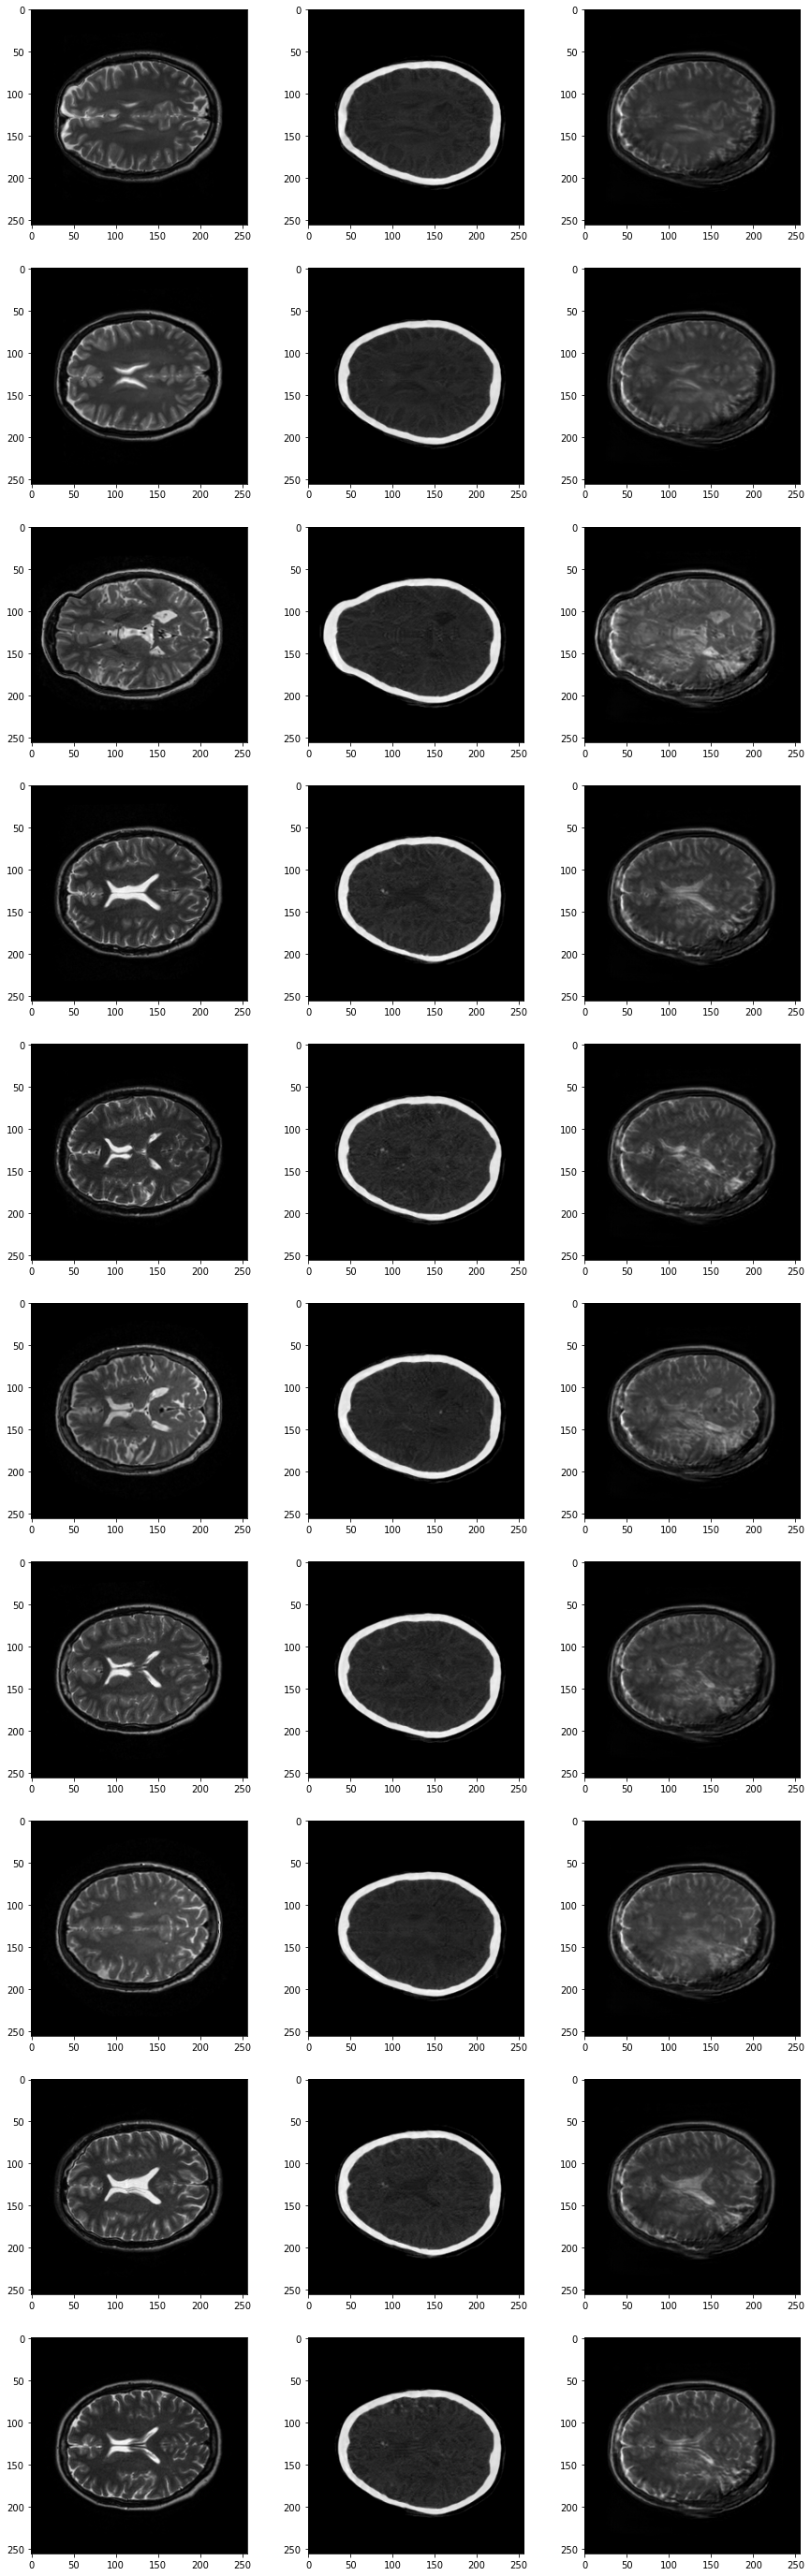

In [13]:
plot_sample_cycle_GAN(T2Dataset_test, fake_CT_test, fake_fake_T2_test, 10)

### Plotting CT => T2 Scan => CT Scan


<Figure size 432x288 with 0 Axes>

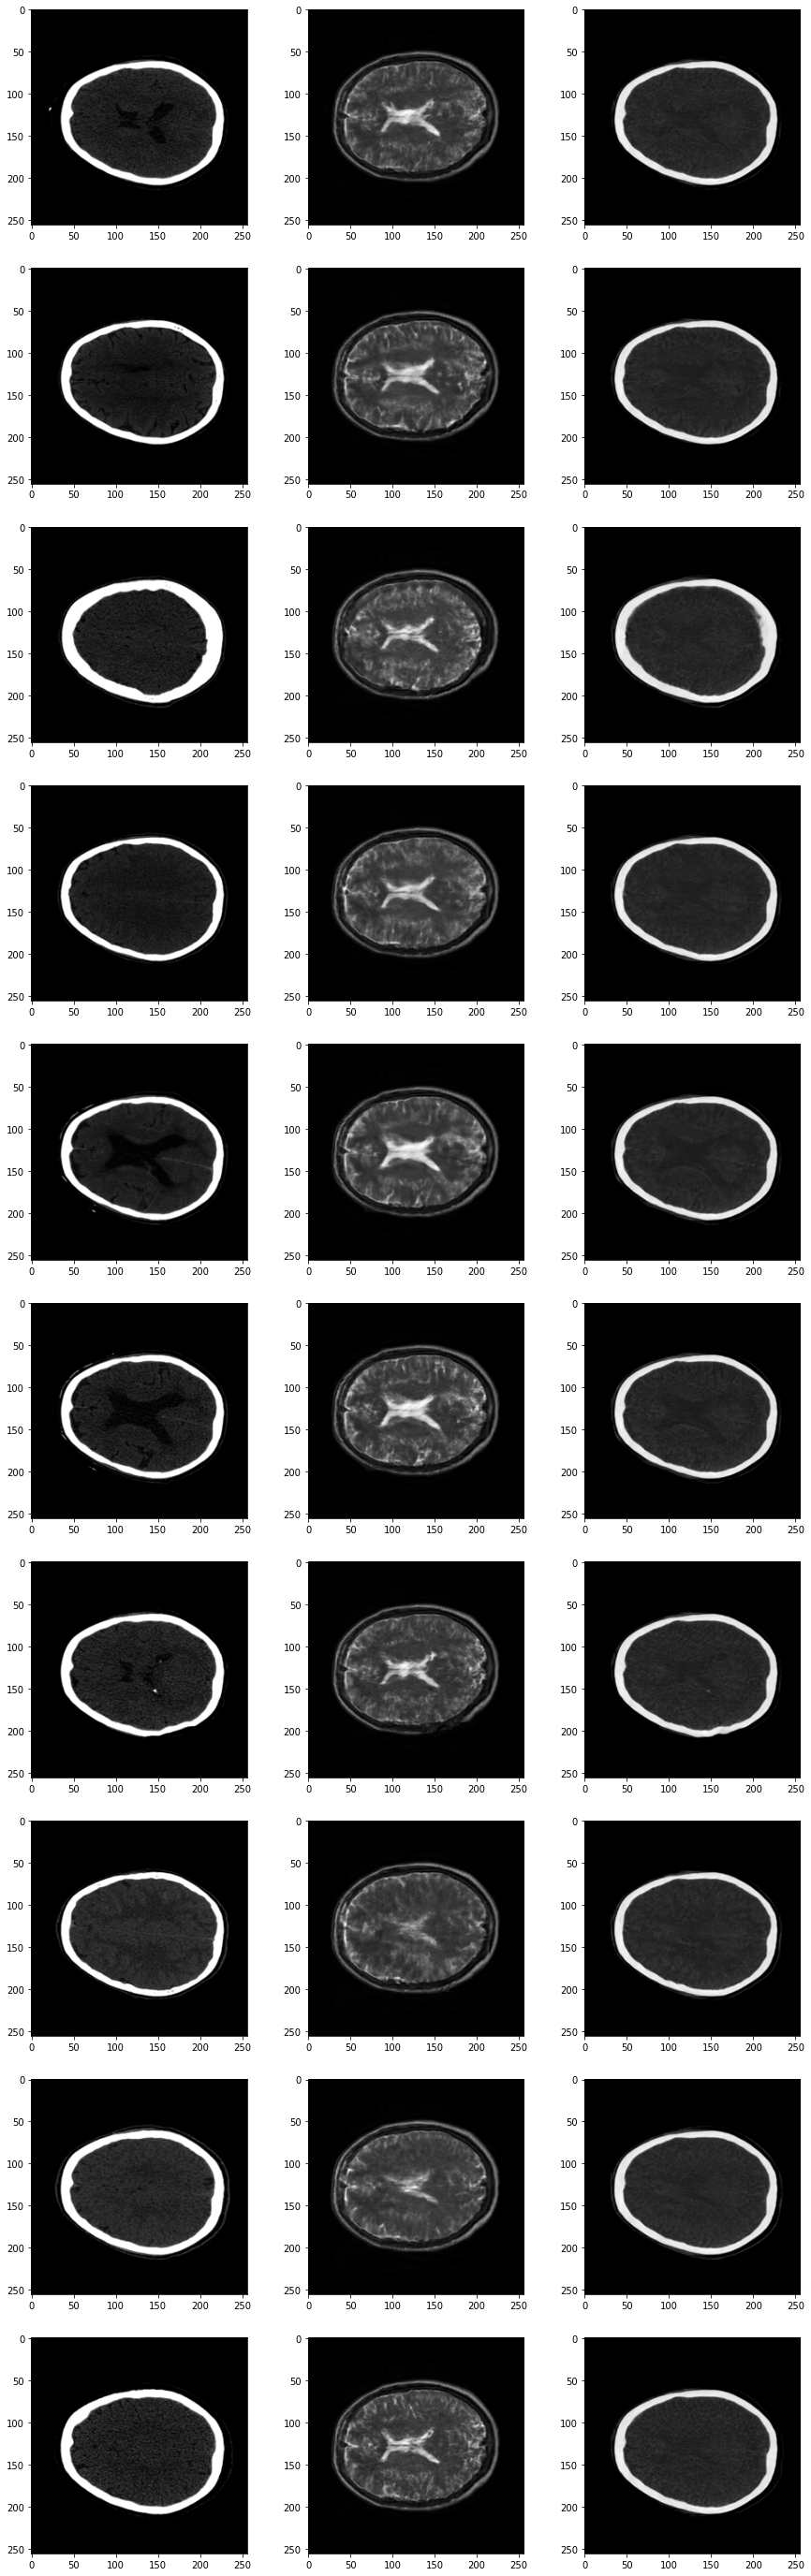

In [14]:
plot_sample_cycle_GAN(CTDataset_test, fake_T2_test, fake_fake_CT_test, 10)

## Computing metrics (FID, ...)


The Frechet Inception Distance, or FID for short, is a metric for evaluating the quality of generated images and specifically developed to evaluate the performance of generative adversarial networks.

Inception score measures the quality of a generated image by computing the KLdivergence between the (logit) response produced by this image and the marginal
distribution, i.e., the average response of all the generated images, using an Inception network trained on ImageNet. In other words, Inception score does
not compare samples with a target distribution, and is limited to quantifying
the diversity of generated samples. Frechet Inception distance compares Inception activations (responses of the penultimate layer of the Inception network)
between real and generated images.

### Creating Partial Inception Network

In [0]:
class Partial_InceptionNetwork(nn.Module):

      def __init__(self):
        super().__init__()
        self.inception_network = torchvision.models.inception_v3(pretrained=True)
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook) # We want to retrive the output of the layer N-1
      
      def output_hook(self, module, input, output):
        # N x 2048 x 8 x 8
        self.mixed_7c_output = output

      def forward(self, x):

        x = x * 2 -1 # Normalize to [-1, 1]
        # Trigger output hook
        self.inception_network(x)
        # Output: N x 2048 x 8 x 8 
        activations = self.mixed_7c_output
        # Output: N x 2048 x 1 x 1
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1,1))
        activations = activations.view(x.shape[0], 2048)
        return activations

def preprocess_image(im):
    """Resizes and shifts the dynamic range of image to 0-1
    Args:
        im: np.array, shape: (H, W, 3), dtype: float32 between 0-1 or np.uint8
    Return:
        im: torch.tensor, shape: (3, 299, 299), dtype: torch.float32 between 0-1
    """
    im =im.reshape((256,256,1)).numpy()
    im = np.repeat(im,3,-1)
    assert im.shape[2] == 3
    assert len(im.shape) == 3
    if im.dtype == np.uint8:
        im = im.astype(np.float32) / 255
    im = cv2.resize(im, (299, 299))
    im = np.rollaxis(im, axis=2)
    im = torch.from_numpy(im)
    assert im.max() <= 1.0
    assert im.min() >= 0.0
    assert im.dtype == torch.float32
    assert im.shape == (3, 299, 299)

    return im

In [0]:
def get_activation(images, batch_size):
    batch_size=5
    num_images = len(images)
    n_batches = int(np.ceil(num_images  / batch_size)) # Get number of batch w.r.t the batch size
    inception_activations = np.zeros((num_images, 2048), dtype=np.float32)

    for batch_idx in range(n_batches):
            start_idx = batch_size * batch_idx # Get start index
            end_idx = batch_size * (batch_idx + 1) # Get end index

            ims = images[start_idx:end_idx]
            ims = ims.cuda()
            activations = model(ims) # Get the output of the N-1 layer
            activations = activations.detach().cpu().numpy()
            inception_activations[start_idx:end_idx, :] = activations 
    return inception_activations


# calculate frechet inception distance
def calculate_fid(act1, act2, eps=1e-6):
	# calculate mean and covariance statistics
  mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
  mu1 = np.atleast_1d(mu1)
  mu2 = np.atleast_1d(mu2)
  sigma1 = np.atleast_2d(sigma1)
  sigma2 = np.atleast_2d(sigma2)

  diff = mu1 - mu2
	
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
  if not np.isfinite(covmean).all():
    msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
    warnings.warn(msg)
    offset = np.eye(sigma1.shape[0]) * eps
    covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

  # numerical error might give slight imaginary component
  if np.iscomplexobj(covmean):
    if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
      m = np.max(np.abs(covmean.imag))
      raise ValueError("Imaginary component {}".format(m))
    covmean = covmean.real

  tr_covmean = np.trace(covmean)

  return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
      

## Compute FID score for CT fake VS CT

In [17]:
model = Partial_InceptionNetwork()
model = model.cuda()
model.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


Partial_InceptionNetwork(
  (inception_network): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(

In [18]:
tensor_fakeCT = [np.clip(img.cpu().numpy(),a_min=0,a_max=1) for img in fake_CT_test]  
tensor_fakeCT = torch.Tensor(tensor_fakeCT)
dataset_fakeCT = torch.utils.data.TensorDataset(tensor_fakeCT) # Get the list in a torch dataset

final_images_real_CT = torch.stack([preprocess_image(im) for im in CTDataset_test], dim=0)
final_images_fake_CT = torch.stack([preprocess_image(im[0].cpu()) for im in dataset_fakeCT], dim=0)


print(final_images_real_CT.shape)
print(final_images_fake_CT.shape)

# Get the output of the N-1 layer of Inception_v3 network
inception_activations_real = get_activation(final_images_real_CT,5) 
inception_activations = get_activation(final_images_fake_CT,5)

# Compute Frechet Inception Distance
score = calculate_fid(inception_activations_real, inception_activations)

print("Frechet Inception Distance for CT : ",score)

torch.Size([111, 3, 299, 299])
torch.Size([85, 3, 299, 299])
Frechet Inception Distance for CT :  71.50161391416535


## Compute FID score for T2 vs T2 fake


In [19]:
tensor_fakeT2 = [np.clip(img.cpu().numpy(),a_min=0,a_max=1) for img in fake_T2_test]  
tensor_fakeT2 = torch.Tensor(tensor_fakeT2)
dataset_fakeT2 = torch.utils.data.TensorDataset(tensor_fakeT2) # Get the list in a torch dataset

final_images_real_T2 = torch.stack([preprocess_image(im) for im in T2Dataset_test], dim=0)
final_images_fake_T2 = torch.stack([preprocess_image(im[0].cpu()) for im in dataset_fakeT2], dim=0)


print(final_images_real_T2.shape)
print(final_images_fake_T2.shape)

# Get the output of the N-1 layer of Inception_v3 network
inception_activations_real = get_activation(final_images_real_T2,5) 
inception_activations = get_activation(final_images_fake_T2,5)

# Compute Frechet Inception Distance
score = calculate_fid(inception_activations_real, inception_activations)

print("Frechet Inception Distance for T2 : ",score)

torch.Size([85, 3, 299, 299])
torch.Size([111, 3, 299, 299])
Frechet Inception Distance for T2 :  80.82004378623539


### Compute SSIM metric


$
\operatorname{SSIM}(x, y)=\frac{\left(2 \mu_{x} \mu_{y}+c_{1}\right)\left(2 \sigma_{x y}+c_{2}\right)}{\left(\mu_{x}^{2}+\mu_{y}^{2}+c_{1}\right)\left(\sigma_{x}^{2}+\sigma_{y}^{2}+c_{2}\right)}
$

with:
$\cdot \mu_{x}$ the average of $x$ \\
$\cdot \mu_{y}$ the average of $y$ \\
$\cdot \sigma_{x}^{2}$ the variance of $x$ \\
$\cdot \sigma_{y}^{2}$ the variance of $y$ \\
$\cdot \sigma_{x y}$ the covariance of $x$ and $y$ \\
$\cdot c_{1}=\left(k_{1} L\right)^{2}, c_{2}=\left(k_{2} L\right)^{2}$ two variables to stabilize the division with weak denominator; \\
$\cdot L$ the dynamic range of the pixel-values (typically this is $2^{\text {#fitits per pixel }}-1$ ); \\
$\cdot k_{1}=0.01$ and $k_{2}=0.03$ by default.


In [0]:
def compute_mean_ssim(real_images,fake_images):
    ssim_all = []
    for real_img in real_images:
      real_img = real_img.reshape((256,256)).numpy()
      for fake_img in fake_images:
        fake_img = fake_img[0].reshape((256,256)).cpu().numpy()
        ssim_all.append(ssim(real_img,fake_img))
    return np.mean(ssim_all)

In [21]:
print("SSIM for train T2 dataset vs Fake T2 : ",compute_mean_ssim(T2Dataset_test,fake_T2_test))
print("SSIM for train CT dataset vs Fake CT : ",compute_mean_ssim(CTDataset_test,fake_CT_test))

SSIM for train T2 dataset vs Fake T2 :  0.8006152714412044
SSIM for train CT dataset vs Fake CT :  0.8790328687678721
